# Setup

In [1]:
%matplotlib inline  
import pandas as pd
import os

In [ ]:
# connection to the database
import os
from sqlalchemy import create_engine

# set username/password here:
db = {'username': os.environ['USERNAME_11323671'],
      'password': os.environ['PASSWORD_11323671'],
      'host': 'quantleap.nl:5432',
      'catalog': 'qir'}

con = 'postgresql://{username}:{password}@{host}/{catalog}'.format(**db)
engine = create_engine(con, echo=True)

print(con)

# Insolvents

In [3]:
sql = """select count(distinct case_number) 
         from company_insolvents"""

no_insolvents = pd.read_sql(sql, con).iloc[0][0]
print('the total number of insolvents cases in the database is {}'.format(no_insolvents))

the total number of insolvents cases in the database is 49883


In [4]:
sql = """select start_date_insolvency is not null as known, count(*)
         from company_insolvents
         group by start_date_insolvency is not null"""

df_known_start_date = pd.read_sql(sql, con)
print('fraction of known start date')
df_known_start_date

fraction of known start date


,known,count
0,False,3873
1,True,46010


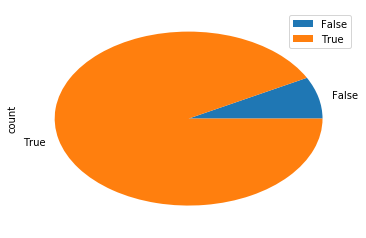

In [5]:
df_known_start_date.plot.pie(y='count', labels=df_known_start_date['known'])

# Judges

In [6]:
sql = """select count(supervisory_judge) as no_cases, supervisory_judge
         from company_insolvents
         group by 2
         order by 1 desc
         limit 10"""

print("top 10 judges by number of cases")
pd.read_sql(sql, con)

top 10 judges by number of cases


,no_cases,supervisory_judge
0,1114,mr. A.E. Zweers
1,1085,mr. C. Schollen-den Besten
2,998,mr. J.S.W. Lucassen
3,909,mr. A.M.P.T. Blokhuis
4,887,mr. P.J. Neijt
5,877,mr. A.E. de Vos
6,801,mr. M Pellikaan
7,768,mr. I.M. Bilderbeek
8,741,mr. S.J.O. de Vries
9,705,mr. M.H.F. van Vugt


## Example of non normalized judge names:

- "mr. W.J.  Geurts - de Veld"
- "mr. W.J. Geurts - de Veld"
- "mr. W.J. Geurts-deVeld"
- "mr. W.J. Geurts-de Veld"
- "mr. W.J.Geurts-de Veld"
- "mr.W.J. Geurts-de Veld"
- "mr. W.J. Geurts-de Veld (Rotterdam)"
- "mr W.J.Geurts-de Veld"
- "W.J.Geurts-de Veld"

correct: "mr. W.J. Geurts-de Veld"
normalized: "wj geurts-de veld"

normalization steps:
1. make lowercase
2. remove leading mr[.]
3. remove spaces around dash
4. remove dots
5. replace double spaces by single space
6. remove parentheses and text within
7. strip leading and trailing spaces


In [7]:
sql = """select distinct supervisory_judge
         from company_insolvents
         order by 1"""

non_normalized_name = pd.read_sql(sql, con)

def normalize_judge_name(name):
    return name.replace(r"\(.*\)","")
    

non_normalized_name['supervisory_judge'].apply(normalize_judge_name)

AttributeError: 'NoneType' object has no attribute 'replace'

In [ ]:
# rechters_df = pd.read_html('http://ors.openstate.eu/relations')[0]
rechters_df = pd.read_json('http://ors.openstate.eu/relations/json')

In [ ]:
rechters_df

In [ ]:
rechters_df[rechters_df['set'] == 'Rechtbank Amsterdam']

# Reports

## steekproef van niet OCR eindverslagen van januari 2018

In [8]:
sql = '''SELECT identification, publication_date, is_end_report, is_ocr, content, start_date_insolvency
         FROM reports rep
             JOIN company_insolvents ins ON rep.insolvent_id = ins.id
         WHERE ins.person_legal_personality = 'rechtspersoon'
             AND rep.is_end_report = TRUE
             AND is_ocr is FALSE
             AND publication_date BETWEEN '2018-02-01' AND '2018-03-31'
         ORDER BY publication_date DESC
         LIMIT 20;'''

df_end_reports_last_week = pd.read_sql(sql, con)
df_end_reports_last_week

,identification,publication_date,is_end_report,is_ocr,content,start_date_insolvency
0,05_gel_16_674_F_V_05,2018-03-29 16:56:24,True,False,advocatuur\n\nwww.editadvoatuuuil\n\nFAILLISSE...,2016-07-19
1,05_gel_16_666_F_V_05,2018-03-29 16:53:40,True,False,advocatuur\n\nwww.editadvoatuuuil\n\nFAILLISSE...,2016-10-18
2,16_mne_16_568_F_V_01,2018-03-29 16:48:46,True,False,advocatuur\n\nwww.editadvoatuuuil\n\nFAILLISSE...,2016-10-18
3,05_gel_16_660_F_V_05,2018-03-29 16:46:56,True,False,advocatuur\n\nwww.editadvoatuuuil\n\nFAILLISSE...,2016-10-18
4,01_obr_13_1204_F_V_04,2018-03-28 16:27:46,True,False,VANIERSEL\nLUCHTMAN\nADVOCATEN\n\nOpenbaar fa...,2013-12-24
5,01_obr_13_293_F_V_09,2018-03-26 15:05:16,True,False,FAILLISSEMENTSVERSLAG\n\nNummer:9\n\nDatum: 2...,2013-03-26
6,01_obr_15_189_F_V_07,2018-03-22 16:50:29,True,False,F\nA\nI\nL\nL\nI\nS\nS\nE\nM\nE\nN\nT\nS\nV\nE...,2015-03-10
7,01_obr_15_188_F_V_08,2018-03-22 16:50:02,True,False,F\nA\nI\nL\nL\nI\nS\nS\nE\nM\nE\nN\nT\nS\nV\nE...,2015-03-10
8,13_ams_14_651_F_V_06,2018-03-21 18:34:06,True,False,Openbaar faillissementsverslag rechtspersoon (...,2014-11-25
9,13_ams_14_497_F_V_07,2018-03-21 18:32:11,True,False,Openbaar faillissementsverslag rechtspersoon (...,2014-09-09


## Data field wish list from the PDF report

### Wenselijke datavelden in het voortgangsverslag
Het voortgangsverslag hoort gestructureerd te zijn volgens de RECOFA richtlijnenm zie **model-verslag-faillissement-rechtspersoon.pdf**. In eerste instantie zijn we geinteresseerd in de data uit de **eindverslagen**.

Algemeen
- Personeel gemiddeld aantal: aantal
- Bestede uren totaal: aantal
- Saldo boedelrekening: bedrag


4 Debiteuren

4.2 Opbrengst: bedrag


7 Rechtmatigheid

7.2 Depot jaarrekeningen: wel/niet 

7.5 Onbehoorlijk bestuur: wel/niet


8 Crediteuren

8.1 Boedelvorderingen: bedrag (salaris curator / UWV / ..)

8.2 Preferente vorderingen van de fiscus: bedrag

8.3 Preferente vorderingen van het UWV: bedrag

8.4 Andere preferente vorderingen: bedrag

8.5 Aantal concurrente crediteuren: bedrag

8.6 Bedrag concurrente crediteuren: bedrag



### Bevindingen
- Bij insolventen van verslagen 13_ams_15_478_F_V_06 en 10_rot_12_90_F_V_16 zijn geen enkele financiele verslagen ook curator salaris wordt niet genoemd. Vraag: wie levert geen financieel verslag en waarom?
- Bij eindverslag 10_rot_14_1054_F_V_10 staat curator salaris alleen in de financiele bijlage. Er lijkt ook sprake van een schikking - regeling bestuurder: 22.000 - wegens rechtmatigheidsissue. 
- bij 11_rot_12_41_F_V_15 staan bedragen doorgestreept, textconversie pakt dat niet
- De eindverslagen zijn niet echt eindverslagen: 'Naar verwachting zal het faillissement in de komende
verslagperiode eindigen.' (11_rot_12_41_F_V_15)
- uurtarief bij 11_rot_12_41_F_V_15 komt op 280,-
- 10_rot_14_1054_F_V_10, 01_obr_13_293_F_V_09 omzetting pdf>txt verliest letters/gegevens/structuur met PDFMiner. Welke converter pakt dit goed aan ?

In [19]:
report_id = '01_obr_13_293_F_V_09'
content = df_end_reports_last_week[df_end_reports_last_week['identification'] == report_id]['content'].iloc[0]
print(content)
# strikethrough komt niet terug in de tekstconversie vb 8.4

FAILLISSEMENTSVERSLAG

Nummer:9

Datum:  26 maart  2018

Gegevens  onderneming

Faillissementsnummer

Datum  uitspraak

Rechter-commissaris

Curator

D.A.H.  Brusselers  Holdinq  B.V.
statutair  gevestigd  te's-Hertogenbosch  en feitelijk
gevestigd  te Drunen  aan  de Laan van Tasmanië (5152
HW).

clo'v131293F

26 maart2013

mr. S.J.O.  de Vries

mr. K.T.W.H.  van den Dungen

Voor zover de tekst in dit verslag afw¡jkt van hetgeen  in het vorige  verslag  is vermeld,  is die
tekst vetged  ru kt weergegeven.

Activiteiten ondernem  ing

De omschrijving  van de activiteiten  van gefailleerde in het handelsregister is:
"Het  beheren  en beleggen  van vermogen,  alsmede het optreden  als houdster  van aandelen in andere
vennootschappen."
Deze  gebruikelijke  omschrijving  voor houdstervennootschappen  sluit in dit geval redelijk  aan op de
werkelijkheid. Er is echter  geen  sprake  geweest  van beleggingen,  maar  uitsluitend  van verrichtingen
ter bestuur  van werkmaatschappij Metselbedrij

## Extracting structured text from PDF reports

In [18]:
# Personeel gemiddeld aantal
import re

flags = re.DOTALL | re.IGNORECASE

def first_match_group():
    pass

def match_block_personeel_gemiddeld_aantal(pattern, content):
    match = re.search(pattern, content, flags)
    return match.group(0) if match else None
    

def match_personeel_gemiddeld_aantal(content):
    patterns = [r'gemiddeld\s+aantal\s+personeel(.*?)verslagperiode',
                r'personeel\s+gemiddeld\s+aantal(.*?)saldo\s+einde\s+verslagperiode'
                r'PersoneelSaldo  ei nde verslagperiode
               ]
    
    
    for pattern in patterns:
        block = match_block_personeel_gemiddeld_aantal(pattern, content)
        import pdb; pdb.set_trace
        if block:
            return block
    return None

#print(match_personeel_gemiddeld_aantal(content))

content = df_end_reports_last_week['content'].apply(match_personeel_gemiddeld_aantal)
content

0     Gemiddeld aantal personeel:\n\nnihil\nalle vie...
1     Gemiddeld aantal personeel:\n\nnihil\nalle vie...
2     Gemiddeld aantal personeel:\n\nnihil\nalle vie...
3     Gemiddeld aantal personeel:\n\nnihil\nalle vie...
4     Personeel  gemiddeld  aantal  12\n\nSaldo eind...
5                                                  None
6                                                  None
7                                                  None
8                                                  None
9                                                  None
10                                                 None
11                                                 None
12                                                 None
13                                                 None
14    Personeel gemiddeld aantal \n \n \nSaldo einde...
15                                                 None
16    Personeel gemiddeld aantal\n\nSaldo einde vers...
17                                              